### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants

### Testing the MATH Dataset

In [2]:
from data_classes.MathDataLoader import MathDataLoader
from data_classes.MathProblem import MathProblem
from llm_agents.ChainOfThoughtMathSolver import ChainOfThoughtMathSolver

math_data_loader = MathDataLoader(data_dir=constants.MATH_DATASET_DIR)
# random_problem = math_data_loader.get_random_problem(level=1)
random_problem = math_data_loader.get_problem(type="algebra", problem_number=265)

math_solver = ChainOfThoughtMathSolver()
response = math_solver(random_problem.problem_statement)

print(random_problem)
print(random_problem.problem_statement)
# 
# print(response)

random_problem.is_correct_answer(response, verbose=True)

Loaded 5000 math problems from 7 problem types
MATH problem number 265 of type Algebra with level 5 and answer \boxed{-102}.
Let $S$ be the set of all real numbers $\alpha$ such that the function \[\frac{x^2+5x+\alpha}{x^2 + 7x - 44}\]can be expressed as a quotient of two linear functions. What is the sum of the elements of $S$?
Level: 5 | Response: \boxed{-11} | Answer: \boxed{-102} | Is Correct: False


False

In [3]:
# results = math_data_loader.test_random_problems(math_solver, n_problems=10, level=1, verbose=True)

### Running MACM

In [4]:
import utils
if not os.getenv("OPENAI_API_KEY") or  not os.getenv("TAVILY_API_KEY"):
    os.environ["OPENAI_API_KEY"] = utils.get_openai_api_key()
    os.environ["TAVILY_API_KEY"] = utils.get_tavily_api_key()

In [5]:
run_raw_macm = False

if run_raw_macm:
    sys.path.append(os.path.abspath("MACM/"))

    from MACM.main import main as main_macm

    n = 1 # verification times
    times = 5 # The upper limit of the mining times
    min_voters = 1 # min number of voters
    max_voters = 1 # max number of voters
    problem_statement = random_problem.problem_statement

    main_macm(problem_statement, times, n, min_voters, max_voters)  # Assuming these are defined elsewhere

### LangChain MACM

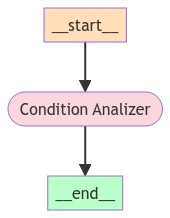

Conditions: 
['The function can be expressed as a quotient of two linear functions.']
Objectives: 
['Find the sum of the elements of the set S.']
Event: {'Condition Analizer': {'math_problem': <data_classes.MathProblem.MathProblem object at 0x7faf793f5c00>, 'unverified_conditions': ['The function can be expressed as a quotient of two linear functions.'], 'objectives': ['Find the sum of the elements of the set S.']}}


In [20]:
from multi_agent_graph import get_multi_agent_summarizer_graph
from IPython.display import Image, display


config = {"recursion_limit": 50}
inputs = {
    "math_problem": random_problem,
    "n": 1,
}

graph = get_multi_agent_summarizer_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

for event in app.stream(inputs, config=config):
    print("Event:", event)